### Init

In [70]:
import os
import yaml

import torch
from torch.utils.data import DataLoader, Dataset
from tqdm.notebook import tqdm

from datasets import load_dataset
from segment.sam_results import SAMResults
from segment.utils import (get_coco_style_polygons, pad_to_fixed_size,
                   resize_preserve_aspect_ratio)
from segment.grounded_sam import (
    run_grounded_sam_batch,
    transform_image_dino,
    transform_image_sam,
)
from segment.utils import get_device

import json
from datasets import Value
from huggingface_hub import create_repo
from segment.utils import convert_coco_polygons_to_mask, overlay_mask
from PIL import Image
import random

## Notebook Purpose: 
- Get all masks related to text prompts from a dataset and push the new dataset to 🤗

### Config

In [71]:
def load_yaml(path):
    with open(path, "r") as file:
        data = yaml.load(file, Loader=yaml.FullLoader)
    return data

def get_labels_dict(config_path):
    data = load_yaml(config_path)
    labels_dict = data.get("names")
    labels_dict = {v: k for k, v in labels_dict.items()}
    return labels_dict


def get_masks_md(results):
    results_list = []
    for result in results.formatted_results:
        mask = result.get("mask")
        coco_polygons = get_coco_style_polygons(mask)

        # format the polygons
        result.update({"polygons": coco_polygons})
        result.pop("mask")
        results_list.append(result)
    return results_list

In [72]:
# Set the cache dir
cache_dir = "hf_cache"

# Torch Settings
batch_size = 8
num_workers = os.cpu_count()
device = get_device()

# Get the labels from the yolo config file
config_path = "configs/fashion_people_detection.yml"

data = load_yaml(config_path)

labels_dict = get_labels_dict(config_path)
labels = [k for k, v in labels_dict.items()]
text_prompt = " . ".join(labels)
text_prompt

'hair . face . neck . arm . hand . back . leg . foot . outfit . person . phone'

### Dataset

In [73]:
# Enter the dataset ID and load it as a torch dataset
dataset_id = "MnLgt/fashion_people_detections"
split='train[:100]'

# Enter the repo name to push the new dataset to
new_repo_id = "jordandavis/fashion_people_detections"

### Dataloader

In [74]:
def resize_image_pil(image_pil):
    if image_pil.mode != "RGB":
        image_pil = image_pil.convert("RGB")
    image_pil = resize_preserve_aspect_ratio(image_pil, 1024)
    image_pil = pad_to_fixed_size(image_pil, (1024, 1024))
    return image_pil


class Segmentation(Dataset):
    def __init__(self, dataset_id=None, image_col="image", image_id_col=None, split='train'):
        self.ds = load_dataset(
            dataset_id, split=split, trust_remote_code=True, cache_dir=cache_dir, num_proc=os.cpu_count()
        )
        self.image_col = image_col
        self.image_id_col = image_id_col
        self.imgsz = 1024

    def __len__(self):
        return len(self.ds)

    def __getitem__(self, idx):
        item = self.ds[idx]

        # Get Image ID defaults to index
        image_id = item.get(self.image_id_col, idx)

        # Get PIL Image
        image_pil = item[self.image_col]
        # if image_pil.size[0] != self.imgsz or image_pil.size[1] != self.imgsz:
        #     image_pil = resize_image_pil(image_pil)
        image_pil = resize_image_pil(image_pil)


        # Process dino image
        dino_image = transform_image_dino(image_pil)

        # Process sam image
        sam_image = transform_image_sam(image_pil)

        return {"image_id": image_id, "dino_image": dino_image, "sam_image": sam_image, "image_pil": image_pil}

In [75]:
ds = Segmentation(dataset_id=dataset_id, image_col="image", image_id_col=None, split=split)

Resolving data files:   0%|          | 0/20 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/20 [00:00<?, ?it/s]

Setting num_proc from 30 to 20 for the train split as it only contains 20 shards.


Generating train split:   0%|          | 0/23279 [00:00<?, ? examples/s]

In [76]:
# ds.ds = ds.ds.filter(lambda x: x['num_people'] > 0)
# a = ds.ds['num_people']
# b = [i for i, x in enumerate(a) if x > 0]
# c = ds.ds.select(b)
# ds.ds = c

In [77]:
# Dataloader
def collate_fn(ex):
    dino_images = torch.stack([e["dino_image"] for e in ex])
    sam_images = torch.stack([e["sam_image"] for e in ex])
    image_ids = [e["image_id"] for e in ex]
    pil_images = [e["image_pil"] for e in ex]
    return dict(image_ids=image_ids, dino_images=dino_images, sam_images=sam_images, pil_images=pil_images)


dataloader = DataLoader(
    ds,
    collate_fn=collate_fn,
    batch_size=batch_size,
    num_workers=num_workers,
    pin_memory=True,
    shuffle=False,
)

### Run Inference

In [78]:
os.environ["TOKENIZERS_PARALLELISM"] = "true"
masks_md = []
with tqdm(total=len(dataloader)) as pbar:
    for batch in dataloader:
        image_ids = batch.get("image_ids")
        images = batch.get("pil_images")

        with torch.no_grad():
            dino_images = batch.get("dino_images").to(device)
            sam_images = batch.get("sam_images").to(device)
            raw_results = run_grounded_sam_batch(dino_images, sam_images, text_prompt)

        for image_id, image, raw_result in zip(image_ids, images, raw_results):
            if raw_result.get('masks') is None or ('person' not in raw_result.get("phrases")):
                mask_md = None
            else:
                result = SAMResults(image, labels_dict, **raw_result)
                mask_md = get_masks_md(result)

            masks_md.append(mask_md)
        pbar.update(1)

  0%|          | 0/13 [00:00<?, ?it/s]

In [80]:
updated_ds = ds.ds.take(len(masks_md))
updated_ds = updated_ds.add_column("mask_metadata2", masks_md)
# updated_ds = updated_ds.cast_column("width", Value("int16"))
# updated_ds = updated_ds.cast_column("height", Value("int16"))

Label: outfit
Score: 0.353691965341568


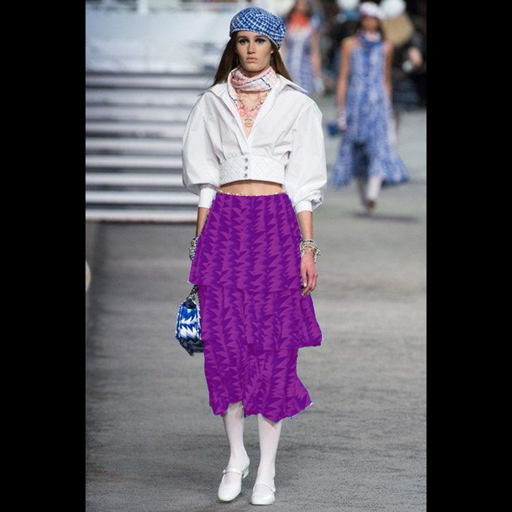

In [115]:
def sanity_check(ds, row=102, mask_row=2,image_col="image", metadata_col='mask_metadata'):
    image = ds[row][image_col]
    image = resize_image_pil(image)

    polygons = ds[row][metadata_col][mask_row]['polygons']
    label = ds[row][metadata_col][mask_row]['label']
    score = ds[row][metadata_col][mask_row]['score']
    
    mask = convert_coco_polygons_to_mask(polygons, 1024, 1024)
    mask_image = Image.fromarray(mask)
    overlay = overlay_mask(image, mask_image, opacity=0.8)

    print(f"Label: {label}")
    print(f"Score: {score}")
    display(overlay.resize((512, 512)))

metadata_col = 'mask_metadata2'
row = random.randint(0, len(updated_ds))
mask_row = random.randint(0, len(updated_ds[row][metadata_col]) - 1)
sanity_check(updated_ds, row, mask_row)

### Push To Hub

In [ ]:
# # Filter out rows with no mask_metadata
# a = updated_ds['mask_metadata']
# b = [i for i, x in enumerate(a) if x is not None]
# updated_ds = updated_ds.select(b)
# ds_len = len(updated_ds)
# print(f"Dataset Length: {ds_len}")

# create_repo(
#     repo_id=new_repo_id,
#     repo_type="dataset",
#     exist_ok=True,
# )

# updated_ds.push_to_hub(new_repo_id, commit_message="md")